In [5]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements(is_chapter7_v2=True)

In [6]:
from utils import *
setup_chapter()

Using transformers v4.36.2
Using datasets v2.16.1


In [7]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [8]:
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Question Answering

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="images/chapter07_marie-curie.png" id="marie-curie"/>

## Building a Review-Based QA System

### The Dataset

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="images/chapter07_phone.png" id="phone"/>

In [9]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [10]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [11]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [12]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [13]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].iloc[[1]]
sample_df

,title,question,answers.text,answers.answer_start,context
1,B00001P4ZH,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]",To anyone who hasn't tried all the various typ...


In [14]:
type(sample_df)

pandas.core.frame.DataFrame

In [15]:
start_idx = sample_df["answers.answer_start"]
start_idx

1    [1302, 1302]
Name: answers.answer_start, dtype: object

In [16]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'Bass is weak as expected'

In [17]:
dfs["train"]["question"].str.startswith("How").value_counts()[True]

780

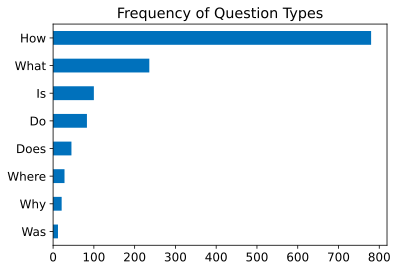

In [18]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [19]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Sidebar: The Stanford Question Answering Dataset

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="images/chapter07_squad-sota.png" id="squad-sota"/>

### End sidebar

### Extracting Answers from Text

#### Span classification

<img alt="QA Head" caption="The span classification head for QA tasks" src="images/chapter07_qa-head.png" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="images/chapter07_squad-models.png" id="squad-models"/> 

#### Tokenizing text for QA

In [20]:
from transformers import AutoTokenizer

model_ckpt = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [21]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [22]:
#hide_input
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
input_ids,0,6179,203,930,64,42,946,116,2,2,...,98,59,36300,722,6122,15,2870,1836,4,2
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [23]:
print(tokenizer.decode(inputs["input_ids"][0]))

<s>How much music can this hold?</s></s>An MP3 is about 1 MB/minute, so about
6000 hours depending on file size.</s>


In [24]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 1.1276, -8.1721,
-8.4530, -7.9752, -8.5254, -8.6735, -8.0572, -9.5367,
         -9.3867, -8.4349,  0.9319,  0.8909, -5.2955, -2.7966,  2.0575,  3.4133,
         -1.2010, -4.3265, -3.2173, -5.5264, -1.5662,  1.4979,  2.3764, -2.6608,
         -3.6962, -7.0487, -3.4079, -5.4748, -4.6754, -8.8369]]),
end_logits=tensor([[ 1.4499, -7.7060, -6.7904, -6.1389, -7.5058, -7.3799,
-6.7995, -6.7666,
         -7.4103, -6.0500, -4.6616, -4.7859,  1.4522, -4.2961, -2.7452, -1.4223,
          0.2536, -0.7084,  4.0795, -0.3075, -4.6912, -3.9767,  0.0340,  3.1081,
         -3.2529, -4.7419, -3.2038,  1.0621,  0.9285, -7.0004]]),
hidden_states=None, attentions=None)


In [25]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [26]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 30])
Start logits shape: torch.Size([1, 30])
End logits shape: torch.Size([1, 30])


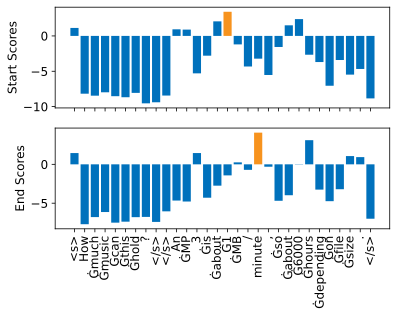

In [27]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens—the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [28]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer:  1 MB/minute


In [29]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=5)

[{'score': 0.28984513878822327,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'},
 {'score': 0.10971563309431076,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.07470741122961044,
  'start': 10,
  'end': 27,
  'answer': 'about 1 MB/minute'},
 {'score': 0.0389024056494236, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.0282791405916214,
  'start': 10,
  'end': 48,
  'answer': 'about 1 MB/minute, so about 6000 hours'}]

In [30]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9933502078056335, 'start': 0, 'end': 0, 'answer': ''}

#### Dealing with long passages

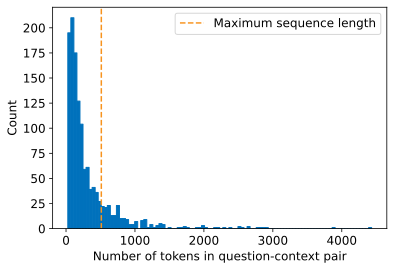

In [31]:
#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="images/chapter07_sliding-window.png" id="sliding-window"/>

In [32]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [33]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 95 tokens


In [34]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

<s>How is the bass?</s></s>I have had Koss headphones in the past, Pro 4AA and
QZ-99.  The Koss Portapro is portable AND has great bass response.  The work
great with my Android phone and can be "rolled up" to be carried in my
motorcycle jacket or computer bag without getting crunched.  They are very light
and do not feel heavy or bear down on your ears even after listening to music
with them on all day</s>

<s>How is the bass?</s></s> They are very light and do not feel heavy or bear
down on your ears even after listening to music with them on all day.  The sound
is night and day better than any ear-bud could be and are almost as good as the
Pro 4AA.  They are "open air" headphones so you cannot match the bass to the
sealed types, but it comes close. For $32, you cannot go wrong.</s>



### Using Haystack to Build a QA Pipeline

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="images/chapter07_retriever-reader.png" id="retriever-reader"/>

#### Initializing a document store

In [35]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "hoppetusse",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "KUCMNX7dTpCt4D-vT3ZovA",
  "version" : {
    "number" : "8.12.0",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "1665f706fd9354802c02146c1e6b5c0fbcddfbc9",
    "build_date" : "2024-01-11T10:05:27.953830042Z",
    "build_snapshot" : false,
    "lucene_version" : "9.9.1",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


In [36]:
from haystack.pipelines import Pipeline

In [37]:
# from haystack.components.embedders import SentenceTransformersDocumentEmbedder

In [38]:
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.nodes import TextConverter, PreProcessor 

document_store = ElasticsearchDocumentStore(host = "localhost", port = 9200)

This ElasticsearchDocumentStore has been built for Elasticsearch 7, but the detected version of the Elasticsearch server is 8.12.0. Unexpected behaviors or errors may occur due to version incompatibility.


In [39]:
from haystack.nodes import EmbeddingRetriever

retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
# Important:
# Now that we initialized the Retriever, we need to call update_embeddings() to iterate over all
# previously indexed documents and update their embedding representation.
# While this can be a time consuming operation (depending on the corpus size), it only needs to be done once.
# At query time, we only need to embed the query and compare it to the existing document embeddings, which is very fast.
#document_store.update_embeddings(retriever)

/home/olav/dev/miniconda3/envs/book/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [40]:
import itertools
tmp = [df["review_id"].tolist() for _, df in dfs.items()]
ids = list(itertools.chain(*tmp))
if len(document_store.get_all_documents()) > 0:
    document_store.delete_documents()


Since version 1.0 of Haystack, Documents now have a field `content`, which replaces the field `text`. This change was introduced because Documents have become more flexible and can also store tables in addition to texts.

In [41]:
from haystack import Document
for split, df in dfs.items():
# Exclude duplicate reviews
    docs = [Document(content=row["context"], id=row["review_id"],
    meta={"item_id": row["title"], "question_id": row["id"], 
            "split": split})
for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs)    

In [42]:
print(f"Loaded {len(document_store.get_all_documents())}" + " documents")

Loaded 1615 documents


#### Initializing a retriever

In Haystack 1.4 `ElasticsearchRetriever` was renamed to `BM25Retriever`. You can still use `ElasticsearchRetriever` for compatibility reasons in version 1.5 but it might be removed in future releases.

In [43]:
from haystack.nodes import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [44]:
item_id = "B0074BW614"
# query = "Is it good for reading?"
query = "How fast is it?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [45]:
print(retrieved_docs[0])

<Document: id=f0a3986796ef137641a08e2ea944ae62, content='this is a great
electronic device. Works perfect and the price was very good! Is very fast and
the a...'>


#### Initializing a reader

In [46]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [47]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=2))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64808964729309,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293065905570984, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids':
['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>, <Answer {'answer': '',
'type': 'extractive', 'score': 0.43940970527698286, 'context': None,
'offsets_in_document': [{'start': 0, 'end': 0}], 'offsets_in_context':
[{'start': 0, 'end': 0}], 'document_ids': None, 'meta': {}}>]}


#### Putting it all together

In [48]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

The format of parameters that can be passed to a pipeline has slightly changed. In the old version, the method call was 
```python
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})
```
Now, you can specify the name of the node, e.g., `"Retriever"`, that you want to pass parameters to.

In [49]:
n_answers = 3
query = "battery lifetime?"
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: battery lifetime?

Answer 1:
Review snippet: ...None...



Answer 2: Battery life is solid
Review snippet: ...few movies in HD and the PQ is excellent. Sound quality is
good. Battery life is solid. I'm actually on my second. When I received the
first Kindle in...



Answer 3: Laptops battery life is not as good as the Kindle
Review snippet: ...with it can be challenging because it is so small. Laptops
battery life is not as good as the Kindle.  So the Fire combines for me what I
needed all t...





## Improving Our QA Pipeline

### Evaluating the Retriever

Evaluating the retriever is the same as evaluating a `DocumentSearchPipeline`, which consists only of a single node, a retriever.

In [50]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

Since version 1.0 of Haystack, `Answer` has become a class and each `Label` contains a `Document` that the `Label` refers to. Thus, the initialization of a `Label` in the following code cell has changed.
Note that the code printed in the book had a small bug. In the for loop of the old code, `Label`s were created that were all initialized with the same id. Thus they were handled as duplicates and not all of them were stored in the document store when we later on called `document_store.write_labels(labels, index="label")`:
```python
for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
```


*In the previous version there was a bug that omitted some of the labels.*

In [51]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

In [52]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 910 question-answer pairs


In [53]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


Since version 1.0 of Haystack, the evaluation of pipelines is much different compared to the version described in the first edition of the book. `Pipeline` now has a method `eval()`, which runs the pipeline given input data from labels and returns the prediction and the labels in the format of one Pandas dataframe per pipeline node. This result is stored in `eval_result` in the following code cell. On these results, we can calculate arbitrary metrics - without rerunning the computationally intensive inference steps of the pipeline.

In [54]:
# We can run the pipeline with the desired top_k value like this
'''eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 1}},
)
#metrics = eval_result.calculate_metrics()'''

'eval_result = pipe.eval(\n    labels=labels_agg,\n    params={"Retriever": {"top_k": 1}},\n)\n#metrics = eval_result.calculate_metrics()'

In [55]:
#print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

You can check the predictions of any query by inspecting the dataframe:

In [56]:
#eval_df = eval_result["Retriever"]
#eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

Or if we want to calculate metrics for multiple topk values, we can run the pipeline only once with the highest top_k value and calculate metrics for smaller top_ks afterwards.

In [57]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


#bm25_topk_df = evaluate_retriever(bm25_retriever)

In [58]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
#plot_retriever_eval([bm25_topk_df], ["BM25"])

#### Dense Passage Retrieval

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="images/chapter07_dpr.png" id="dpr"/>

In [59]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

In [60]:
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings:  99%|█████████▉| 1600/1616 [00:05<00:00, 310.79 Docs/s]
Updating embeddings: 10000 Docs [00:13, 741.65 Docs/s]                    


In [61]:
#dpr_topk_df = evaluate_retriever(dpr_retriever)
#plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluating the Reader

In [62]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [63]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the `pipeline.eval()` gets the relevant documents as direct input from the labels.

In [64]:
list(zip([1,2,3], ["one", "two", "three"]))

[(1, 'one'), (2, 'two'), (3, 'three')]

In [65]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
#reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In the first version no_answer labels weren't taken into account. Because there are quite many of them in the evaluation dataset the numbers differ significantly compared to the first version (EM was at ~0.07 and f1 at ~0.25).

In [66]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

#plot_reader_eval(reader_eval)

### Domain Adaptation

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="images/chapter07_squad-schema.png" id="squad-schema"/>

In [67]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [68]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [69]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [70]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

'''
reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)
'''

'\nreader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,\n             train_filename=train_filename, dev_filename=dev_filename)\n'

In [71]:
#reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

In [72]:
#plot_reader_eval(reader_eval)

In [73]:
'''
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)
                           '''

'\nminilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"\nminilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,\n                           max_seq_len=max_seq_length, doc_stride=doc_stride,\n                           return_no_answer=True)\n                           '

In [74]:
#minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
#            train_filename=train_filename, dev_filename=dev_filename)

In [75]:
#reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

In [76]:
#plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [77]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

'''

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
#metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
'''

'\n\n# Evaluate!\neval_result = pipe.eval(\n    labels=labels_agg,\n    params={},\n)\n#metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)\n# Extract metrics from reader\nreader_eval["QA Pipeline (top-1)"] = {\n    k:v for k,v in metrics["Reader"].items()\n    if k in ["exact_match", "f1"]}\n'

In [78]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
'''
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})
'''

'\nplot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], \n                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})\n'

In [79]:
# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
'''
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
#metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
#isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

#plot_reader_eval(pipeline_reader_eval)
'''

'\neval_result = pipe.eval(\n    labels=labels_agg,\n    params={},\n    add_isolated_node_eval=True\n)\n#metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)\n# Extract metrics from reader run in isolation with simulated perfect retriever\n#isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")\n\npipeline_reader_eval = {}\npipeline_reader_eval["Reader"] = {\n    k:v for k,v in isolated_metrics["Reader"].items()\n    if k in ["exact_match", "f1"]}\npipeline_reader_eval["QA Pipeline (top-1)"] = {\n    k:v for k,v in metrics["Reader"].items()\n    if k in ["exact_match", "f1"]}\n\n#plot_reader_eval(pipeline_reader_eval)\n'

## Going Beyond Extractive QA

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="images/chapter07_rag-architecture.png" id="rag"/>

### Retrieval-Augmented Generation

In [82]:
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser
model = "meta-llama/Llama-2-7b-chat-hf"
model = "mistralai/Mistral-7B-Instruct-v0.2"
#model = "google/flan-t5-large"
rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
                             Provide a clear and concise response that summarizes the key points and information presented in the text.
                             Your answer should be in your own words and be no longer than 50 words.
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

#prompt_node = PromptNode(model_name_or_path=model, default_prompt_template=rag_prompt, use_gpu=True)


In [81]:
from haystack.pipelines import Pipeline

pipe = Pipeline()
pipe.add_node(component=dpr_retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])


In [91]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query) 
    print(f"Question: {preds['query']} \n")
    #for idx in range(top_k_generator):
    print(f"Answer {0}: {preds['answers'][0].answer}")

In [92]:
generate_answers(query)

The prompt has been truncated from 2799 tokens to 412 tokens so that the prompt length and answer length (100 tokens) fit within the max token limit (512 tokens). Shorten the prompt to prevent it from being cut off


Question: battery lifetime?

Answer 0: This smartphone meets my needs.. The size is just right, the battery
life is good, it is fairly easy to download apps, and with TracFone, you get
Triple Minutes For Life!!! Easy to program, works.


In [93]:
generate_answers("What is the main drawback?")

The prompt has been truncated from 1190 tokens to 412 tokens so that the prompt length and answer length (100 tokens) fit within the max token limit (512 tokens). Shorten the prompt to prevent it from being cut off


Question: What is the main drawback?

Answer 0: Roku 3 is a good product, but it's not worth the money.


## Conclusion

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="images/chapter07_qa-pyramid.png" id="qa-pyramid"/> 